## Recommender System for Airbnb Listings in Seattle

Author: Hatice K. Erdogan 

Add pic
Table of Contents 

# Data Pre-processing 

In [16]:
# Importing relevant libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

The listings dataset contains 92 columns in total. However, I want my recommender to be based only on id, name, summary, space and description of each listing, so these are the only columns I considered in modeling.  

In [2]:
df = pd.read_csv('Data/listings.csv', usecols=['id', 'name', 'summary', 'space', 'description', 'neighborhood_overview','notes','transit'])
df.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ..."
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,NaN,NaN,NaN
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...


In [3]:
# Now I have 3818 listings with 8 columns describing listings' attributes 
df.shape

(3818, 8)

In [4]:
df.isna().sum()

id                          0
name                        0
summary                   177
space                     569
description                 0
neighborhood_overview    1032
notes                    1606
transit                   934
dtype: int64

# Preprocess the Texts in Columns  

In [5]:
import re
import string

In [6]:
# Fill missing values with empty strings. When we combine the rows as one row for each listing, null values will have no effect. 
df['summary'] = df['summary'].fillna('')
df['space'] = df['space'].fillna('')
df['neighborhood_overview'] = df['neighborhood_overview'].fillna('')
df['notes'] = df['notes'].fillna('')
df['transit'] = df['transit'].fillna('')

In [7]:
# Creating a new column that combines all the columns with descriptions of the listings
df['content'] = df[['name','summary','space','description','neighborhood_overview','notes','transit']].astype(str).apply(lambda x: ' '.join(x),axis=1)
df['content'].head()

0    Stylish Queen Anne Apartment  Make your self a...
1    Bright & Airy Queen Anne Apartment Chemically ...
2    New Modern House-Amazing water view New modern...
3    Queen Anne Chateau A charming apartment that s...
4    Charming craftsman 3 bdm house Cozy family cra...
Name: content, dtype: object

In [8]:
df.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit,content
0,241032,Stylish Queen Anne Apartment,,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,,,,Stylish Queen Anne Apartment Make your self a...
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",Bright & Airy Queen Anne Apartment Chemically ...
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,New Modern House-Amazing water view New modern...
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,,A charming apartment that sits atop Queen Anne...,,,,Queen Anne Chateau A charming apartment that s...
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,Charming craftsman 3 bdm house Cozy family cra...


In [9]:
# Contractions are words or combinations of words that are shortened by dropping letters and replacing them by an apostrophe.
# Removing contractions to standardize text 

import contractions
expanded_words = []   
for word in df['content']:
# Using contractions.fix to expand the shortened words
  expanded_words.append(contractions.fix(word))  
   
df['content'] = expanded_words

In [10]:
df['content'][1]

"Bright & Airy Queen Anne Apartment Chemically sensitive? We have removed the irritants triggering allergy or asthma attacks, like carpeting, forced air & used pillows, all culprits that harbor fungus, mold & bacteria.  No smoking, no pets.  Designed for healthy living, so breathe easy. Beautiful, hypoallergenic apartment in an extremely safe, quiet and pedestrian-friendly section of Queen Anne.  A leafy-green location that puts the best of Seattle at your doorstep. Free WiFi, free parking, ...even free pillows!  What is special about this place? Hypo-allergenic bedding, mattresses/covers and new pillows with each rental. (So feel free to take your new pillows with you!)  A beautiful restoration mixing period details & modern sensibilities: Hardwood floors throughout, white subway tile, low/no VOCs & non-toxic paints keep this home-away-from-home clean, smart and healthy. Radiant heat and oil radiators mean no blowing hot air or dust.  Great Amenities: Free WiFi & internet TV (LED flat

In [11]:
# Creating a function that will preprocess and standardize the text for NLP 
def preprocess(text):
    ''' This function takes text to preprocess and standardize it for the purpose of NLP '''
 
    # Lowercase the text 
    text = text.str.lower()
    
    # Remove punctuations using string module with regular expression
    text = text.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

    # Remove word and digits 
    #text = text.apply(lambda x: re.sub('W*dw*','', x))

    # Split string by whitespace and remoce extra whitespaces 
    text = text.apply(lambda x: x.split())

    # Remove stopwords 
    import nltk
    stopwords = nltk.corpus.stopwords.words('english')
    text = text.apply(lambda x: [word for word in x if word not in stopwords])

    # Lemmatize text to group together words with the same root or lemma
    from nltk.stem.wordnet import WordNetLemmatizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    text = text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    text = text.apply(lambda x: ' '.join(x))

    return text

In [12]:
df['content'] = preprocess(df['content'])
df['content'][1]

'bright airy queen anne apartment chemically sensitive removed irritant triggering allergy asthma attack like carpeting forced air used pillow culprit harbor fungus mold bacteria smoking pet designed healthy living breathe easy beautiful hypoallergenic apartment extremely safe quiet pedestrian friendly section queen anne leafy green location put best seattle doorstep free wifi free parking even free pillow special place hypo allergenic bedding mattress cover new pillow rental feel free take new pillow beautiful restoration mixing period detail modern sensibility hardwood floor throughout white subway tile low vocs non toxic paint keep home away home clean smart healthy radiant heat oil radiator mean blowing hot air dust great amenity free wifi internet tv led flatscreen fully equipped kitchen stainless steel appliance sink disposal large washer dryer iron ironing board hairdryer plenty storage convenient parking street best location enjoy seattle celebrated macrina bakery neighborhood 

## Count Vectorizer 

I vectorized the words with Count Vectorizer first, then I will implement TF-IDF Vectorizer and see their differences and decide on which one will be helpful building the recommendation system. 

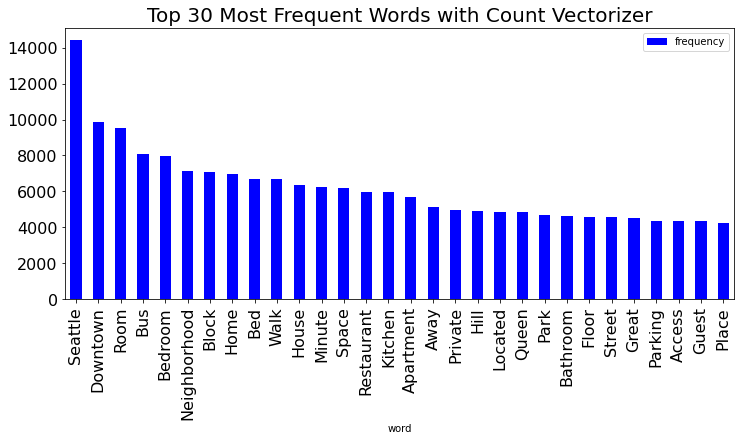

In [51]:
# Convert the content column to a matrix of word counts
# Most frequent words with Count Vectorizer
cv = CountVectorizer(stop_words='english', ngram_range=(1,2))
cv_matrix = cv.fit_transform(df['content'])
cv_total = cv_matrix.sum(axis=0)

cv_freq = [(word.title(), cv_total[0, i]) for word, i in cv.vocabulary_.items()]
cv_freq = sorted(cv_freq, key = lambda x: x[1], reverse = True)
cv_frequency = pd.DataFrame(cv_freq, columns=['word', 'frequency'])

# Plotting Top 30 Most Frequent Words with CV 
cv_frequency.head(30).plot(x='word', y='frequency', kind='bar', figsize=(12, 5), color = 'blue')
plt.title('Top 30 Most Frequent Words with Count Vectorizer', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

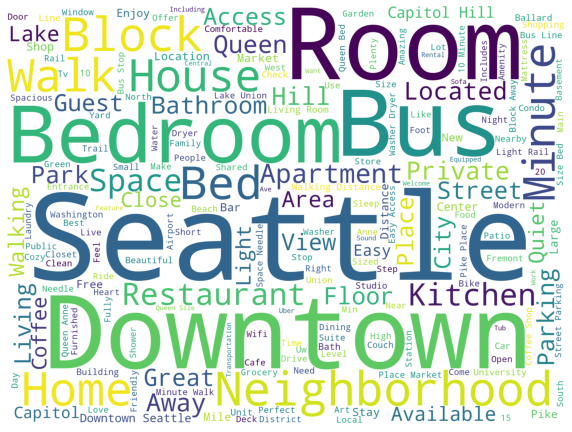

In [23]:
# Wordcloud of the words with Count Vectorizer 
from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(cv_freq))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off');

## Simple Recommender with Count Vectorizer 

Below is a simple recommender function with count vectorizer. It asks user to enter some characteristics of listings they are interested in. 

In [27]:
def recommend_five():
    ''' This function asks the user a question and then takes in the answer to finds the top 5 similar listings '''
    
    question = input('What are some features you are interested in? ')
    inquiry = cv.transform([question])
    similarity = cosine_similarity(inquiry, cv_matrix)
    nums = np.argsort(similarity[0])[-5:]
    return df['name'].loc[nums]

In [65]:
# Recommend five listings with the answer 'free parking'
recommend_five()

416       Sweet+Cozy+Safe Studio in Seattle
845             Artistic home, free parking
866      Cozy Private Loft Apt with Balcony
1632    Private Bedroom, Bathroom,& Parking
349     Wallingford 2 Bedroom Cozy Craftman
Name: name, dtype: object

In [12]:
query = cv.transform(['I want an apartment in queen anne with parking'])
print(cosine_similarity(query, vectorized))

[[0.27841345 0.17175652 0.23240052 ... 0.02677398 0.03806418 0.22961557]]


In [24]:
similarity = cosine_similarity(query, vectorized)
np.argsort(similarity[0])[-5:]


array([3154, 3184,  481, 3172, 3201])

In [25]:
np.argmax(similarity[0])

3201

In [26]:
df.loc[3201]

id                                                                 7921289
name                                   open   bedroom   balcony  city view
summary                  enjoy your own apartment on the top of queen a...
space                           open one bedroom with a balcony and views 
description              enjoy your own apartment on the top of queen a...
neighborhood_overview    this apartment is located on the top of queen ...
notes                                                                     
transit                  downtown is a   minute bus ride away  bus stop...
content                  open   bedroom   balcony  city view,enjoy your...
Name: 3201, dtype: object

## TF-IDF Vectorizer 

I vectorized word with TF-IDF using Unigrams, Bigrams and Trigrams 

## TF-IDF Unigram

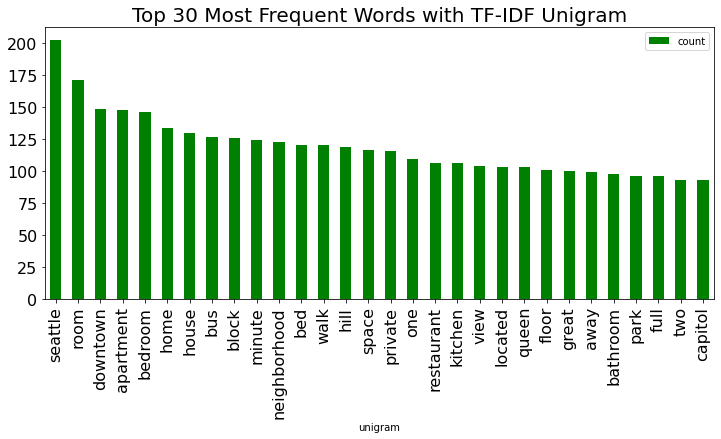

In [35]:
# Converting text descriptions into vectors using TF-IDF using Unigrams
tf = TfidfVectorizer(ngram_range=(1, 1), lowercase = False)
tf_matrix = tf.fit_transform(df['content'])
tf_total = tf_matrix.sum(axis=0) 
# Finding the word frequency
tf_freq = [(word, tf_total[0, idx]) for word, idx in tf.vocabulary_.items()]
tf_freq = sorted(tf_freq, key = lambda x: x[1], reverse=True)
# Converting into dataframe 
unigram = pd.DataFrame(tf_freq, columns = ['unigram', 'count'])

# Plotting the bigram distribution of top 30 words 
unigram.head(30).plot(x='unigram', y='count', kind='bar', figsize=(12, 5), color = 'green')
plt.title('Top 30 Most Frequent Words with TF-IDF Unigram', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

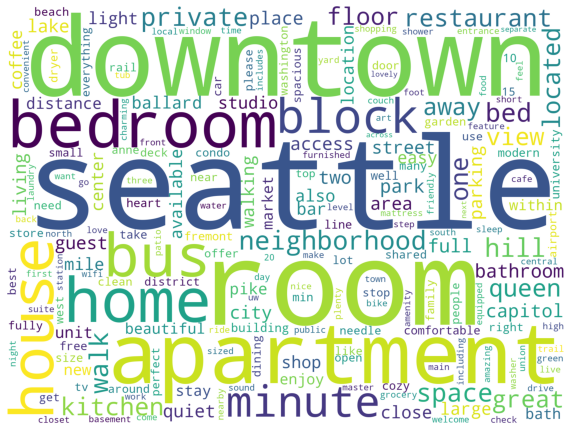

In [36]:
# Wordcloud of the words with TF-IDF Vectorizer with Unigram
from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(tf_freq))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off');

## TF=IDF Unigram & Bigram 

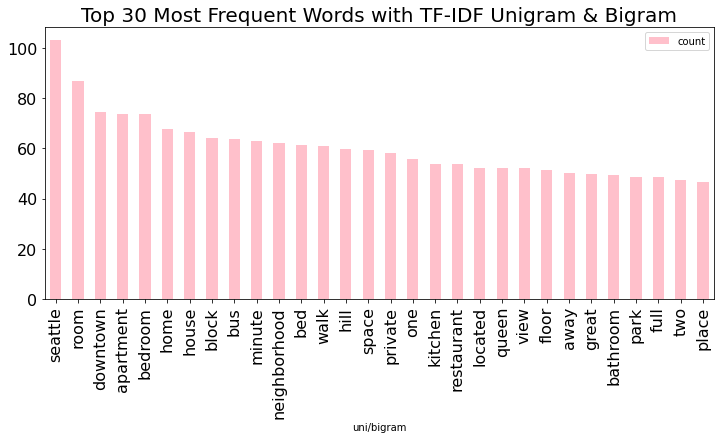

In [69]:
# Converting text descriptions into vectors using TF-IDF using Unigrams & Bigrams
tf1 = TfidfVectorizer(ngram_range=(1, 2), lowercase = False)
tf1_matrix = tf1.fit_transform(df['content'])
tf1_total = tf1_matrix.sum(axis=0) 
# Finding the word frequency
tf1_freq = [(word, tf1_total[0, idx]) for word, idx in tf1.vocabulary_.items()]
tf1_freq = sorted(tf1_freq, key = lambda x: x[1], reverse=True)
# Converting into dataframe 
unibigram = pd.DataFrame(tf1_freq, columns = ['uni/bigram', 'count'])

# Plotting the bigram distribution of top 30 words 
unibigram.head(30).plot(x='uni/bigram', y='count', kind='bar', figsize=(12, 5), color = 'pink')
plt.title('Top 30 Most Frequent Words with TF-IDF Unigram & Bigram', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

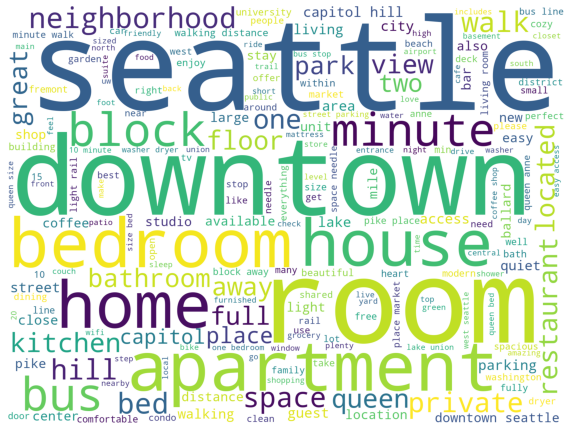

In [70]:
# Wordcloud of the words with TF-IDF Vectorizer with Unigram & Bigram
from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(tf1_freq))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off');

## TF-IDF Bigram 

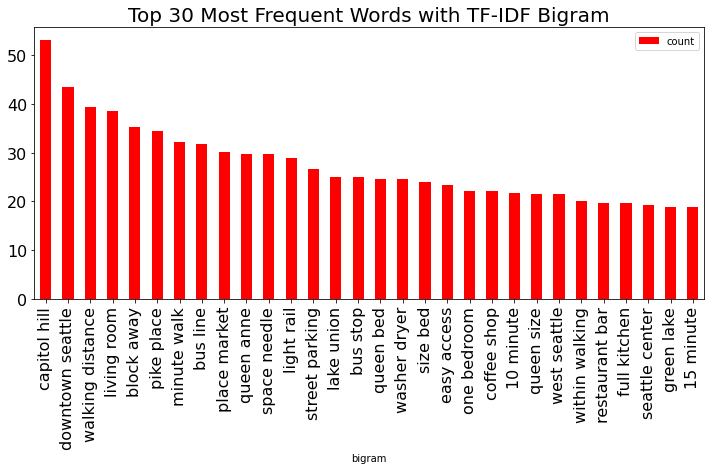

In [71]:
# Converting text descriptions into vectors using TF-IDF using Bigram
tf2 = TfidfVectorizer(ngram_range=(2, 2), lowercase = False)
tf2_matrix = tf2.fit_transform(df['content'])
tf2_total = tf2_matrix.sum(axis=0) 
# Finding the word frequency
tf2_freq = [(word, tf2_total[0, idx]) for word, idx in tf2.vocabulary_.items()]
tf2_freq = sorted(tf2_freq, key = lambda x: x[1], reverse=True)
# Converting into dataframe 
bigram = pd.DataFrame(tf2_freq, columns = ['bigram', 'count'])

# Plotting the bigram distribution of top 30 words 
bigram.head(30).plot(x='bigram', y='count', kind='bar', figsize=(12, 5), color = 'red')
plt.title('Top 30 Most Frequent Words with TF-IDF Bigram', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

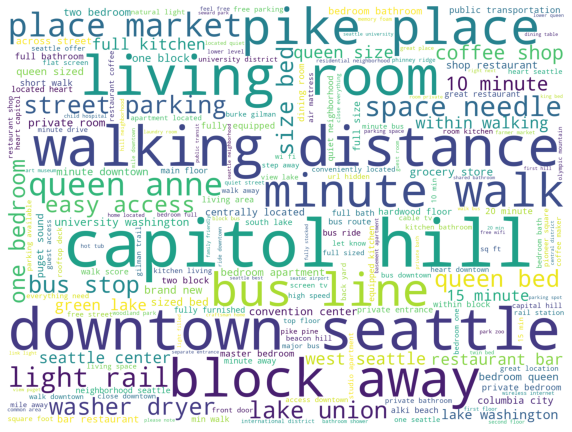

In [72]:
# Wordcloud of the words with TF-IDF Vectorizer with Bigram
from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(tf2_freq))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off');

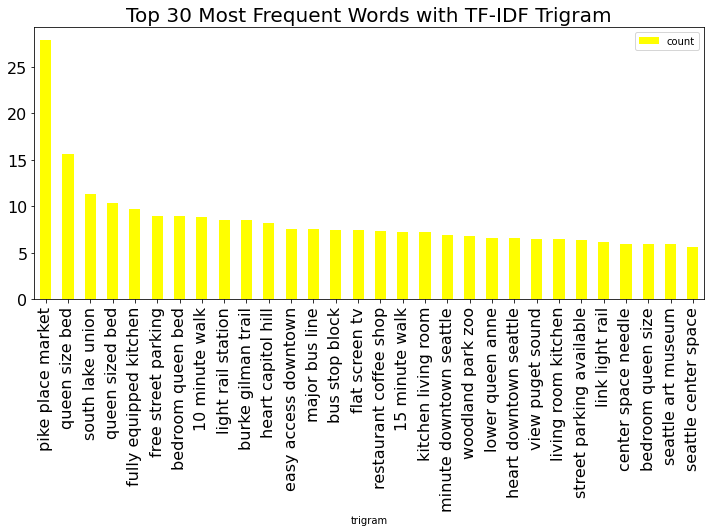

In [73]:
# Converting text descriptions into vectors using TF-IDF using Trigram
tf3 = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tf3_matrix = tf3.fit_transform(df['content'])
tf3_total = tf3_matrix.sum(axis=0) 

# Finding the word frequency
tf3_freq = [(word, tf3_total[0, idx]) for word, idx in tf3.vocabulary_.items()]
tf3_freq =sorted(tf3_freq, key = lambda x: x[1], reverse=True)
# Converting into dataframe 
trigram = pd.DataFrame(tf3_freq, columns = ['trigram', 'count'])

# Plotting the trigram distribution of top 30 words 
trigram.head(30).plot(x='trigram', y='count', kind='bar', figsize=(12, 5), color = 'yellow')
plt.title('Top 30 Most Frequent Words with TF-IDF Trigram', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

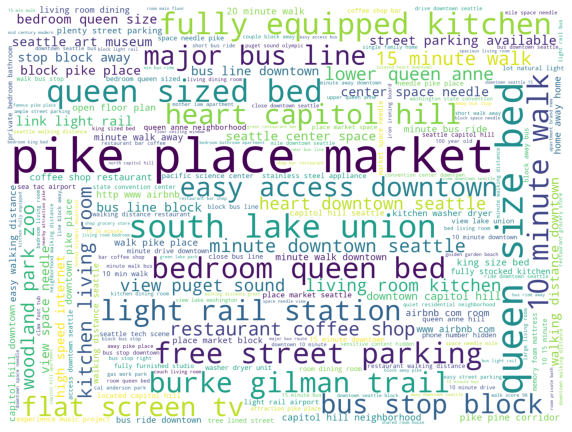

In [74]:
# Wordcloud of the words with TF-IDF Vectorizer with Trigram
from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1500).generate_from_frequencies(dict(tf3_freq))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off');

## Recommender System with TF-IDF 

I will be using cosine similarity to calculate the similarity between listings. Since I used the TF-IDF Vectorizer, I will be using linear_kernel to calculate the dot product that will provide Cosine Similarity Score. 

In [100]:
def recommend(content):
    inquiry = tf2.transform([content])
    similarity = cosine_similarity(inquiry, tf2_matrix)
    nums = np.argsort(similarity[0])[-5:]
    return df['name'].loc[nums]

In [76]:
recommend('free parking three bedroom downtown seattle')

31         Queen Anne 3 bed near everything
2120               Beacon Hill Private Room
1843         Three  bedroom home in Ballard
527     Amazing Huge Modern Green Lake Home
489               3 bedroom Queen Anne Home
Name: name, dtype: object

In [85]:
recommend('free parking pike place market coffee shop 2 bedroom')

1489    Pike Place 2 Blocks, Best Spot! HS2
1466          Pike's Place 1Bed Sunset View
1547      1 Block to PIKE PLACE MARKET! HS2
2330              Seward Park Mother In Law
3172          Spacious Queen Anne townhouse
Name: name, dtype: object

In [39]:
# Using bigrams to calculate similarity because single words don not have much meaning.
cosine_sim = linear_kernel(tf2_matrix, tf2_matrix)

In [86]:
# Comparing each lisitng with every other listing in the dataset
# Each row and each column is a listing from the dataset
cs = cosine_similarity(tf2_matrix)
print(cs)

[[1.00000000e+00 2.69345271e-02 2.16299122e-02 ... 7.43343506e-03
  1.04797802e-02 1.24981747e-02]
 [2.69345271e-02 1.00000000e+00 1.44928429e-02 ... 0.00000000e+00
  8.08366676e-03 1.08406084e-02]
 [2.16299122e-02 1.44928429e-02 1.00000000e+00 ... 0.00000000e+00
  8.80300167e-04 1.21051460e-02]
 ...
 [7.43343506e-03 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  4.55255274e-02 0.00000000e+00]
 [1.04797802e-02 8.08366676e-03 8.80300167e-04 ... 4.55255274e-02
  1.00000000e+00 1.72324911e-02]
 [1.24981747e-02 1.08406084e-02 1.21051460e-02 ... 0.00000000e+00
  1.72324911e-02 1.00000000e+00]]


In [102]:
cs2 = cosine_similarity(tf2_matrix, tf2_matrix)
print(cs2)

[[1.00000000e+00 2.69345271e-02 2.16299122e-02 ... 7.43343506e-03
  1.04797802e-02 1.24981747e-02]
 [2.69345271e-02 1.00000000e+00 1.44928429e-02 ... 0.00000000e+00
  8.08366676e-03 1.08406084e-02]
 [2.16299122e-02 1.44928429e-02 1.00000000e+00 ... 0.00000000e+00
  8.80300167e-04 1.21051460e-02]
 ...
 [7.43343506e-03 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  4.55255274e-02 0.00000000e+00]
 [1.04797802e-02 8.08366676e-03 8.80300167e-04 ... 4.55255274e-02
  1.00000000e+00 1.72324911e-02]
 [1.24981747e-02 1.08406084e-02 1.21051460e-02 ... 0.00000000e+00
  1.72324911e-02 1.00000000e+00]]


In [ ]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])
all_titles = [df2['title'][i] for i in range(len(df2['title']))]

def get_recommendations(title):
    cosine_sim = cosine_similarity(count_matrix, count_matrix)
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    tit = df2['title'].iloc[movie_indices]
    dat = df2['release_date'].iloc[movie_indices]
    return_df = pd.DataFrame(columns=['Title','Year'])
    return_df['Title'] = tit
    return_df['Year'] = dat
    return return_df

In [122]:
# Build a 1-dimensional array with listing contents
#contents = df['content']
df = df.reset_index()
indices = pd.Series(df.index, index = df['content']).drop_duplicates()
#content = [df['content'][i] for i in range(len(df['content']))]

# Function to get listing recommendations based on the cosine similarity score of listings description content
def listing_recommendations(content, cosine_sim=cosine_sim):
    cosine_sim = cosine_similarity(tf2_matrix, tf2_matrix)
    content = [df['content'][i] for i in range(len(df['content']))]
    idx = indices[content]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    listing_indices = [i[0] for i in sim_scores]

    price = df['price'].iloc[listing_indices]
    name = df['name'].iloc[listing_indices]
    #location = df['neighbourhood_group_cleansed'].iloc[listing_indices]
    #property =  df['property_type'].iloc[listing_indices]
    #bedrooms = df['bedrooms'].iloc[listing_indices]
    #guests = df['guests_included'].iloc[listing_indices]
    #review_score = df['review_score_rating'].iloc[listing_indices]
    return_df = pd.DataFrame(columns=['price','name'])
    return_df['name'] = name
    return_df['price'] = price
    return return_df

In [123]:
listing_recommendations('free parking')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()